In [6]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [5]:
dataDir = '/content/drive/Shareddrives/GCCP/GCCP/Raw_data_files/'
outputDir = '/content/drive/Shareddrives/GCCP/GCCP/Output_files/'
modelBuildingDataDir = '/content/drive/Shareddrives/GCCP/GCCP/Data_Model_Building/'
savePlotDir = '/content/drive/Shareddrives/GCCP/GCCP/Output_files/data_Plots/'

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import re
import os
from datetime import datetime

### Import Data for plotting (test)

In [3]:
! ls $outputDir/Tb/model_4/

ls: cannot access '/Tb/model_4/': No such file or directory


In [ ]:
JRJC_test_Tb = pd.read_csv(outputDir + '/JRGC/JRGC_train_Tb.csv')
JRGC_train_Tb = pd.read_csv(outputDir + '/JRGC/JRGC_train_Tb.csv')
GPGC_test_Tb = pd.read_csv(outputDir + '/Tb/model_4/test_data.csv')
GPGC_train_Tb = pd.read_csv(outputDir + '/Tb/model_4/test_data.csv')

In [ ]:
JRJC_test_Tb.columns

Index(['CAS Reg. No.', 'PubChem SMILES', 'Mol. wt.', 'JR Tb /K', 'CRC Tb /K'], dtype='object')

In [ ]:
JRGC_train_Tb.columns

Index(['CAS Reg. No.', 'PubChem SMILES', 'Mol. wt.', 'JR Tb /K', 'CRC Tb /K'], dtype='object')

In [ ]:
GPGC_train_Tb.columns

Index(['Mol. wt.', 'JR Tb /K', 'CRC Tb /K'], dtype='object')

In [ ]:
GPGC_train_Tb.columns

Index(['Mol. wt.', 'JR Tb /K', 'CRC Tb /K'], dtype='object')

In [14]:
# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

def parsePropertyInfo(predicted_col, experimental_col):
    """Extract property name and unit from column headers"""
    # Extract property name (assumes format like "JR Tb /K" or "Method PropertyName /Unit")
    pred_parts = predicted_col.split()
    exp_parts = experimental_col.split()

    # Try to extract property name and unit
    pred_method = pred_parts[0] if len(pred_parts) > 0 else "Predicted"
    exp_method = exp_parts[0] if len(exp_parts) > 0 else "Experimental"

    # Extract property name (middle part)
    if len(pred_parts) >= 2:
        property_name = pred_parts[1]
    else:
        property_name = "Property"

    # Extract unit (part after /)
    pred_unit = ""
    exp_unit = ""

    for part in pred_parts:
        if "/" in part:
            pred_unit = part.split("/")[-1]
            break

    for part in exp_parts:
        if "/" in part:
            exp_unit = part.split("/")[-1]
            break

    # Use the same unit for both (prefer experimental)
    unit = exp_unit if exp_unit else pred_unit

    # Clean up property name
    property_name_clean = property_name.replace("_", " ").title()

    return {
        'property_name': property_name_clean,
        'unit': unit,
        'pred_method': pred_method,
        'exp_method': exp_method,
        'full_property_name': f"{property_name_clean} ({unit})" if unit else property_name_clean
    }

def plotCombinedTrainTestComparison(jrgc_train_path, gpgc_train_path,
                                    jrgc_test_path, gpgc_test_path,
                                    property_name='Property',
                                    jrgc_train_stats=None, gpgc_train_stats=None,
                                    jrgc_test_stats=None, gpgc_test_stats=None,
                                    x_range=None, y_range=None,
                                    savePlotDir='/content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/Plots/'):
    """
    Plot combined train and test data from JRGC and GPGC datasets
    NOTE: Axes are inverted - Experimental on X-axis, Predicted on Y-axis

    Parameters:
    -----------
    jrgc_train_path : str
        Path to JRGC_train_Tb.csv
    gpgc_train_path : str
        Path to GPGC_train_Tb.csv
    jrgc_test_path : str
        Path to JRGC_test_Tb.csv
    gpgc_test_path : str
        Path to GPGC_test_Tb.csv
    property_name : str
        Name of the property for filename (e.g., 'Tb', 'Tc', 'Pc')
    jrgc_train_stats : dict, optional
        Dictionary with keys 'R2', 'MAE', 'RMSE' for JRGC train data
    gpgc_train_stats : dict, optional
        Dictionary with keys 'R2', 'MAE', 'RMSE' for GPGC train data
    jrgc_test_stats : dict, optional
        Dictionary with keys 'R2', 'MAE', 'RMSE' for JRGC test data
    gpgc_test_stats : dict, optional
        Dictionary with keys 'R2', 'MAE', 'RMSE' for GPGC test data
    x_range : tuple, optional
        Range for X-axis (experimental) as (min, max). If None, auto-calculated
    y_range : tuple, optional
        Range for Y-axis (predicted) as (min, max). If None, auto-calculated
    savePlotDir : str
        Directory path to save the plots
    """

    # Read the CSV files
    jrgc_train = pd.read_csv(jrgc_train_path)
    gpgc_train = pd.read_csv(gpgc_train_path)
    jrgc_test = pd.read_csv(jrgc_test_path)
    gpgc_test = pd.read_csv(gpgc_test_path)

    # Get the last two columns (predicted and experimental)
    jrgc_train_pred = jrgc_train.iloc[:, -2]
    jrgc_train_exp = jrgc_train.iloc[:, -1]
    gpgc_train_pred = gpgc_train.iloc[:, -2]
    gpgc_train_exp = gpgc_train.iloc[:, -1]

    jrgc_test_pred = jrgc_test.iloc[:, -2]
    jrgc_test_exp = jrgc_test.iloc[:, -1]
    gpgc_test_pred = gpgc_test.iloc[:, -2]
    gpgc_test_exp = gpgc_test.iloc[:, -1]

    # Get column names for labels
    pred_col_name = jrgc_train.columns[-2]
    exp_col_name = jrgc_train.columns[-1]

    # Parse property info
    prop_info = parsePropertyInfo(pred_col_name, exp_col_name)

    # Create figure with 2 subplots
    fig, axes = plt.subplots(2, 1, figsize=(10, 16))
    fig.suptitle(f'{prop_info["property_name"]} Comparison: JRGC vs GPGC',
                 fontsize=16, fontweight='bold', y=0.995)

    # Calculate overall min and max for consistent axis limits if not provided
    if x_range is None or y_range is None:
        all_pred = pd.concat([jrgc_train_pred, gpgc_train_pred, jrgc_test_pred, gpgc_test_pred])
        all_exp = pd.concat([jrgc_train_exp, gpgc_train_exp, jrgc_test_exp, gpgc_test_exp])

        if x_range is None:
            minVal_x = all_exp.min()
            maxVal_x = all_exp.max()
            padding_x = (maxVal_x - minVal_x) * 0.05
            x_range = (minVal_x - padding_x, maxVal_x + padding_x)

        if y_range is None:
            minVal_y = all_pred.min()
            maxVal_y = all_pred.max()
            padding_y = (maxVal_y - minVal_y) * 0.05
            y_range = (minVal_y - padding_y, maxVal_y + padding_y)

    minVal_x, maxVal_x = x_range
    minVal_y, maxVal_y = y_range

    # ========== TRAIN PLOT (Upper) ==========
    ax_train = axes[0]

    # Plot JRGC train data (red, circle markers) - Changed from blue to red
    # NOTE: Axes inverted - experimental on x, predicted on y
    ax_train.scatter(jrgc_train_exp, jrgc_train_pred,
                     alpha=1.0, s=80, c='red', marker='o',
                     edgecolors='darkblue', linewidths=0.5,
                     label='JRGC Train')

    # Plot GPGC train data (Blue, square markers) - Changed from red to blue
    ax_train.scatter(gpgc_train_exp, gpgc_train_pred,
                     alpha=1.0, s=80, c='blue', marker='s',
                     edgecolors='darkred', linewidths=0.5,
                     label='GPGC Train')

    # Perfect parity line (diagonal from bottom-left to top-right)
    # For parity line, we need the range that covers both axes
    parity_min = min(minVal_x, minVal_y)
    parity_max = max(maxVal_x, maxVal_y)
    ax_train.plot([parity_min, parity_max], [parity_min, parity_max], 'k--', alpha=0.7,
                  linewidth=2, label='Perfect parity')

    # Labels and title (AXES INVERTED)
    ax_train.set_xlabel(f'Experimental {prop_info["full_property_name"]}', fontsize=13, fontweight='bold')
    ax_train.set_ylabel(f'Predicted {prop_info["full_property_name"]}', fontsize=13, fontweight='bold')
    ax_train.set_title('Training Set', fontsize=14, fontweight='bold', pad=10)
    #ax_train.grid(True, alpha=0.3, linestyle='--')
    ax_train.set_xlim(minVal_x, maxVal_x)
    ax_train.set_ylim(minVal_y, maxVal_y)
    ax_train.set_aspect('equal', adjustable='box')
    # Make tick labels bold
    ax_train.tick_params(axis='both', which='major', labelsize=11, width=1.5)
    for label in ax_train.get_xticklabels() + ax_train.get_yticklabels():
        label.set_fontweight('bold')

    # Create legend with only markers (no statistics)
    legend_elements_train = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', # Changed to red
                   markersize=10, markeredgecolor='darkblue', markeredgewidth=0.5,
                   label='JRGC Train'),
        plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='blue', # Changed to blue
                   markersize=10, markeredgecolor='darkred', linewidths=0.5,
                   label='GPGC Train'),

    ]

    legend_train = ax_train.legend(handles=legend_elements_train, loc='upper left',
                                framealpha=0.9, edgecolor='black',prop={'size': 10, 'weight': 'bold'})
    # Set text colors to match markers - Updated colors
    legend_train.get_texts()[0].set_color('red')  # JRGC Train
    legend_train.get_texts()[1].set_color('blue')   # GPGC Train

    # Add statistics as text annotations (outside legend, colored)
    stats_y_position = 0.2  # Starting y position for statistics text
    stats_x_position = 0.5  # x position for statistics text

    if jrgc_train_stats:
        jrgc_stats_text = (f"R² = {jrgc_train_stats.get('R2', 0):.3f}, "
                          f"MAE = {jrgc_train_stats.get('MAE', 0):.2f}, "
                          f"RMSE = {jrgc_train_stats.get('RMSE', 0):.2f}")
        ax_train.text(stats_x_position, stats_y_position, jrgc_stats_text,
                     transform=ax_train.transAxes, fontsize=10,
                     color='red', fontweight='bold', # Changed to red
                     verticalalignment='top', horizontalalignment='left')

    if gpgc_train_stats:
        gpgc_stats_text = (f"R² = {gpgc_train_stats.get('R2', 0):.3f}, "
                          f"MAE = {gpgc_train_stats.get('MAE', 0):.2f}, "
                          f"RMSE = {gpgc_train_stats.get('RMSE', 0):.2f}")
        ax_train.text(stats_x_position, stats_y_position - 0.05, gpgc_stats_text,
                     transform=ax_train.transAxes, fontsize=10,
                     color='blue', fontweight='bold', # Changed to blue
                     verticalalignment='top', horizontalalignment='left')
    '''
    # Add sample count
    ax_train.text(0.98, 0.02, f'n(JRGC)={len(jrgc_train)}, n(GPGC)={len(gpgc_train)}',
                  transform=ax_train.transAxes, fontsize=10,
                  verticalalignment='bottom', horizontalalignment='right',
                  bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    '''
    # ========== TEST PLOT (Lower) ==========
    ax_test = axes[1]

    # Plot JRGC test data (Red, circle markers) - Changed from blue to red
    # NOTE: Axes inverted - experimental on x, predicted on y
    ax_test.scatter(jrgc_test_exp, jrgc_test_pred,
                    alpha=1, s=80, c='red', marker='o',
                    edgecolors='darkblue', linewidths=0.5,
                    label='JRGC Test')

    # Plot GPGC test data (Blue, square markers) - Changed from red to blue
    ax_test.scatter(gpgc_test_exp, gpgc_test_pred,
                    alpha=1, s=80, c='blue', marker='s',
                    edgecolors='darkred', linewidths=0.5,
                    label='GPGC Test')

    # Perfect parity line
    ax_test.plot([parity_min, parity_max], [parity_min, parity_max], 'k--', alpha=0.7,
                 linewidth=2, label='Perfect parity')

    # Labels and title (AXES INVERTED)
    ax_test.set_xlabel(f'Experimental {prop_info["full_property_name"]}', fontsize=13, fontweight='bold')
    ax_test.set_ylabel(f'Predicted {prop_info["full_property_name"]}', fontsize=13, fontweight='bold')
    ax_test.set_title('Test Set', fontsize=14, fontweight='bold', pad=10)
    #ax_test.grid(True, alpha=0.3, linestyle='--')
    ax_test.set_xlim(minVal_x, maxVal_x)
    ax_test.set_ylim(minVal_y, maxVal_y)
    ax_test.set_aspect('equal', adjustable='box')
    # Make tick labels bold
    ax_test.tick_params(axis='both', which='major', labelsize=11, width=1.5)
    for label in ax_test.get_xticklabels() + ax_test.get_yticklabels():
        label.set_fontweight('bold')

    # Create legend with only markers (no statistics)
    legend_elements_test = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', # Changed to red
                   markersize=10, markeredgecolor='darkblue', markeredgewidth=0.5,
                   label='JRGC Test'),
        plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='blue', # Changed to blue
                   markersize=10, markeredgecolor='darkred', linewidths=0.5,
                   label='GPGC Test'),

    ]

    legend_test = ax_test.legend(handles=legend_elements_test, loc='upper left',
                              framealpha=0.9, edgecolor='black', prop={'size': 10, 'weight': 'bold'})
    # Set text colors to match markers - Updated colors
    legend_test.get_texts()[0].set_color('red')  # JRGC Test
    legend_test.get_texts()[1].set_color('blue')   # GPGC Test


    # Add statistics as text annotations (outside legend, colored)
    if jrgc_test_stats:
        jrgc_stats_text = (f"R² = {jrgc_test_stats.get('R2', 0):.3f}, "
                          f"MAE = {jrgc_test_stats.get('MAE', 0):.2f}, "
                          f"RMSE = {jrgc_test_stats.get('RMSE', 0):.2f}")
        ax_test.text(stats_x_position, stats_y_position, jrgc_stats_text,
                    transform=ax_test.transAxes, fontsize=10,
                    color='red', fontweight='bold', # Changed to red
                    verticalalignment='top', horizontalalignment='left')

    if gpgc_test_stats:
        gpgc_stats_text = (f"R² = {gpgc_test_stats.get('R2', 0):.3f}, "
                          f"MAE = {gpgc_test_stats.get('MAE', 0):.2f}, "
                          f"RMSE = {gpgc_test_stats.get('RMSE', 0):.2f}")
        ax_test.text(stats_x_position, stats_y_position - 0.05, gpgc_stats_text,
                    transform=ax_test.transAxes, fontsize=10,
                    color='blue', fontweight='bold', # Changed to blue
                    verticalalignment='top', horizontalalignment='left')
    '''
    # Add sample count
    ax_test.text(0.98, 0.02, f'n(JRGC)={len(jrgc_test)}, n(GPGC)={len(gpgc_test)}',
                 transform=ax_test.transAxes, fontsize=10,
                 verticalalignment='bottom', horizontalalignment='right',
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    '''

    plt.tight_layout()

    # Create output directory if it doesn't exist
    os.makedirs(savePlotDir, exist_ok=True)

    # Generate filename with custom property name
    base_filename = f'{property_name}_GRvsGP'

    # Save in multiple formats
    saved_files = []

    try:
        # Save as PNG (high resolution)
        png_path = os.path.join(savePlotDir, f'{base_filename}.png')
        plt.savefig(png_path, dpi=300, bbox_inches='tight', format='png')
        saved_files.append(png_path)
        print(f" PNG saved: {png_path}")
    except Exception as e:
        print(f" Error saving PNG: {e}")

    try:
        # Save as PDF (vector format)
        pdf_path = os.path.join(savePlotDir, f'{base_filename}.pdf')
        plt.savefig(pdf_path, bbox_inches='tight', format='pdf')
        saved_files.append(pdf_path)
        print(f" PDF saved: {pdf_path}")
    except Exception as e:
        print(f" Error saving PDF: {e}")

    try:
        # Save as EPS (vector format for publications)
        eps_path = os.path.join(savePlotDir, f'{base_filename}.eps')
        plt.savefig(eps_path, bbox_inches='tight', format='eps')
        saved_files.append(eps_path)
        print(f" EPS saved: {eps_path}")
    except Exception as e:
        print(f" Error saving EPS: {e}")

    plt.show()

    # Print summary statistics
    print(f"\nDataset Summary:")
    print("="*80)
    print(f"{'Dataset':<20} {'Samples':<10} {'Experimental Range':<30} {'Predicted Range':<30}")
    print("-"*80)
    print(f"{'JRGC Train':<20} {len(jrgc_train):<10} "
          f"{jrgc_train_exp.min():.2f} - {jrgc_train_exp.max():.2f} {prop_info['unit']:<15} "
          f"{jrgc_train_pred.min():.2f} - {jrgc_train_pred.max():.2f} {prop_info['unit']}")
    print(f"{'GPGC Train':<20} {len(gpgc_train):<10} "
          f"{gpgc_train_exp.min():.2f} - {gpgc_train_exp.max():.2f} {prop_info['unit']:<15} "
          f"{gpgc_train_pred.min():.2f} - {gpgc_train_pred.max():.2f} {prop_info['unit']}")
    print(f"{'JRGC Test':<20} {len(jrgc_test):<10} "
          f"{jrgc_test_exp.min():.2f} - {jrgc_test_exp.max():.2f} {prop_info['unit']:<15} "
          f"{jrgc_test_pred.min():.2f} - {jrgc_test_pred.max():.2f} {prop_info['unit']}")
    print(f"{'GPGC Test':<20} {len(gpgc_test):<10} "
          f"{gpgc_test_exp.min():.2f} - {gpgc_test_exp.max():.2f} {prop_info['unit']:<15} "
          f"{gpgc_test_pred.min():.2f} - {gpgc_test_pred.max():.2f} {prop_info['unit']}")

    print(f"\nAxis ranges used:")
    print(f"X-axis (Experimental): {minVal_x:.2f} - {maxVal_x:.2f} {prop_info['unit']}")
    print(f"Y-axis (Predicted): {minVal_y:.2f} - {maxVal_y:.2f} {prop_info['unit']}")

    print(f"\nPlots saved to: {savePlotDir}")
    print(f"Total files saved: {len(saved_files)}")

    return {
        'saved_files': saved_files,
        'property_info': prop_info,
        'x_range': (minVal_x, maxVal_x),
        'y_range': (minVal_y, maxVal_y)
    }

# Tb

AttributeError: Line2D.set() got an unexpected keyword argument 'linewidths'

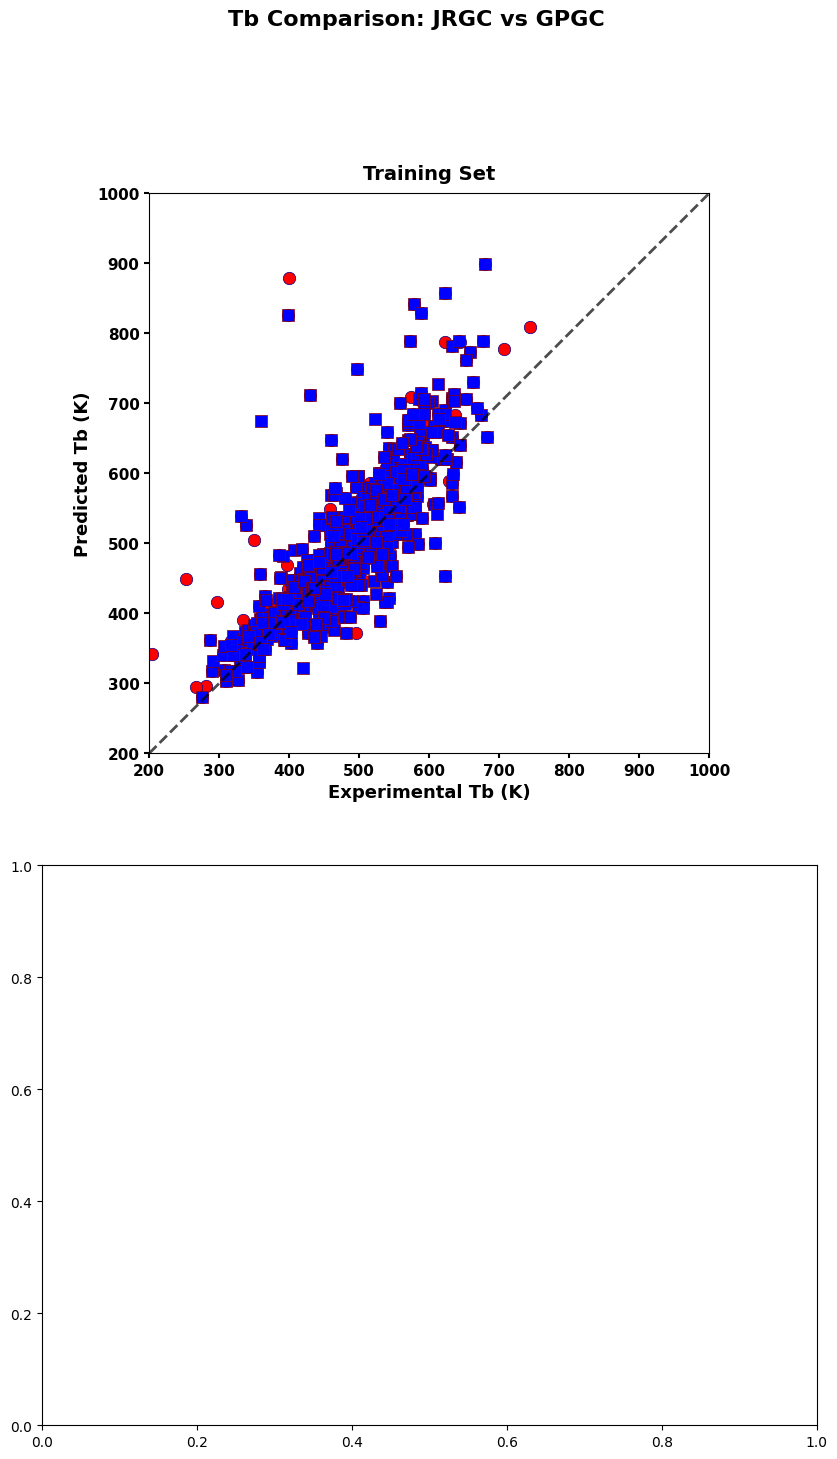

In [17]:
# Example usage
property_name = 'Tb'  # Define property name first

result = plotCombinedTrainTestComparison(
    property_name=property_name,
    jrgc_train_path=outputDir + f'/JRGC/JRGC_train_{property_name}.csv',
    jrgc_test_path=outputDir + f'/JRGC/JRGC_test_{property_name}.csv',
    gpgc_train_path=outputDir + f'/{property_name}/model_4/train_data.csv',
    gpgc_test_path=outputDir + f'/{property_name}/model_4/test_data.csv',
    jrgc_train_stats={'R2': 0.645, 'MAE': 32.52, 'RMSE': 46.974},
    gpgc_train_stats={'R2': 0.786, 'MAE': 26.55, 'RMSE': 36.89},
    jrgc_test_stats={'R2': 0.635, 'MAE': 30.29, 'RMSE': 43.38},
    gpgc_test_stats={'R2': 0.63, 'MAE': 30.55, 'RMSE': 47.05},
    x_range=(200, 1000),  # X-axis (Experimental) range
    y_range=(200, 1000),  # Y-axis (Predicted) range
    savePlotDir=savePlotDir
)

# Access saved file paths
print("\nSaved file paths:")
for file_path in result['saved_files']:
    print(f"  - {file_path}")

# Tm

AttributeError: Line2D.set() got an unexpected keyword argument 'linewidths'

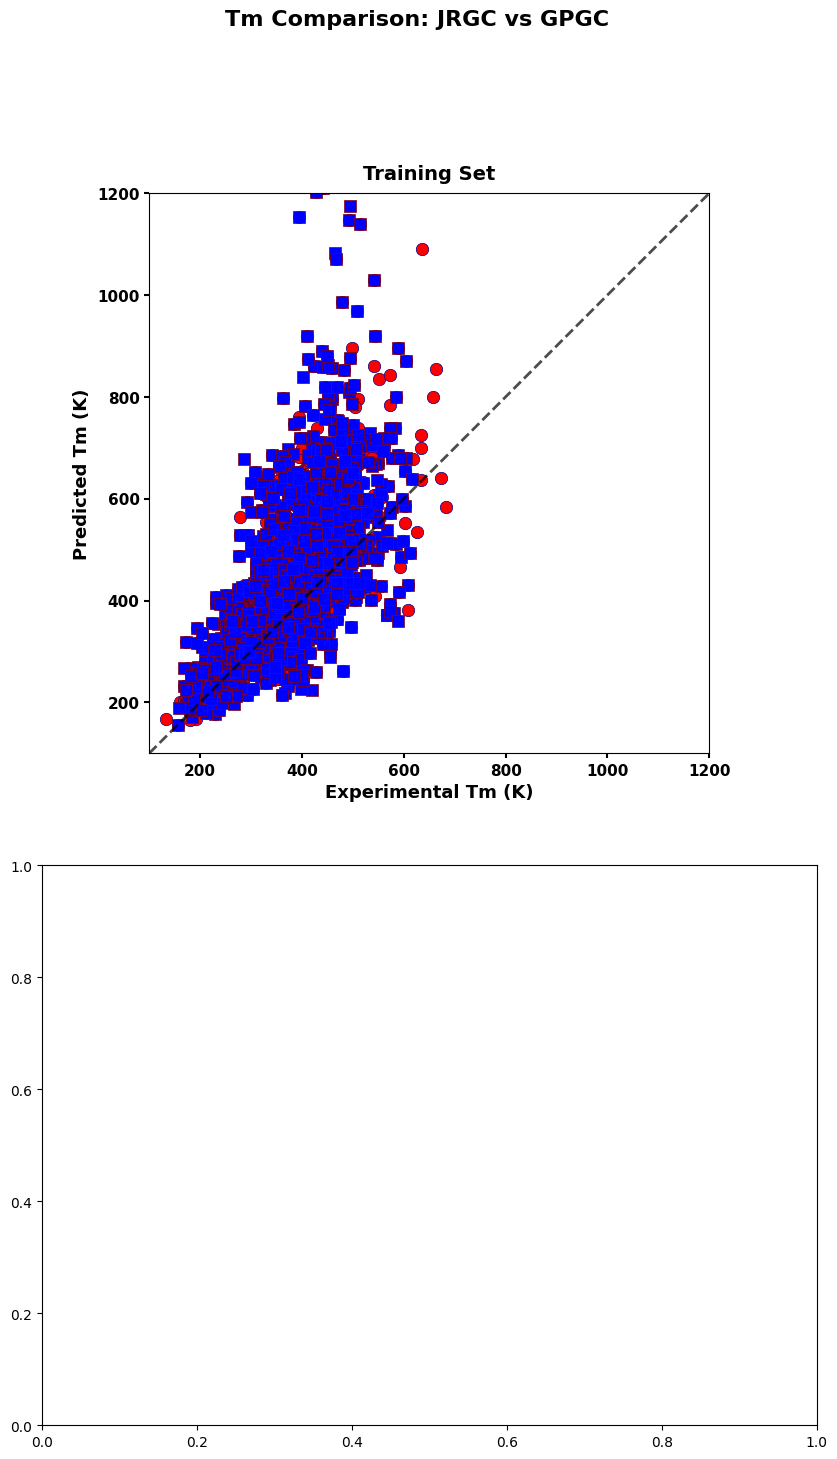

In [13]:
# Example usage
property_name = 'Tm'  # Define property name first

result = plotCombinedTrainTestComparison(
    property_name=property_name,
    jrgc_train_path=outputDir + f'/JRGC/JRGC_train_{property_name}.csv',
    jrgc_test_path=outputDir + f'/JRGC/JRGC_test_{property_name}.csv',
    gpgc_train_path=outputDir + f'/{property_name}/model_4/train_data.csv',
    gpgc_test_path=outputDir + f'/{property_name}/model_4/test_data.csv',
    jrgc_train_stats={'R2': 0.442, 'MAE': 52.264, 'RMSE': 67.41},
    gpgc_train_stats={'R2': 0.584, 'MAE': 45.02, 'RMSE': 58.09},
    jrgc_test_stats={'R2': 0.444, 'MAE': 51.908, 'RMSE': 65.387},
    gpgc_test_stats={'R2': 0.609, 'MAE': 44.01, 'RMSE': 55.83},
    x_range=(100, 1200),  # X-axis (Experimental) range
    y_range=(100, 1200),  # Y-axis (Predicted) range
    savePlotDir=savePlotDir
)

# Access saved file paths
print("\nSaved file paths:")
for file_path in result['saved_files']:
    print(f"  - {file_path}")

# Hvap

 PNG saved: /content/drive/Shareddrives/GCCP/GCCP/Output_files/data_Plots/Hvap_GRvsGP.png


 PDF saved: /content/drive/Shareddrives/GCCP/GCCP/Output_files/data_Plots/Hvap_GRvsGP.pdf
 EPS saved: /content/drive/Shareddrives/GCCP/GCCP/Output_files/data_Plots/Hvap_GRvsGP.eps


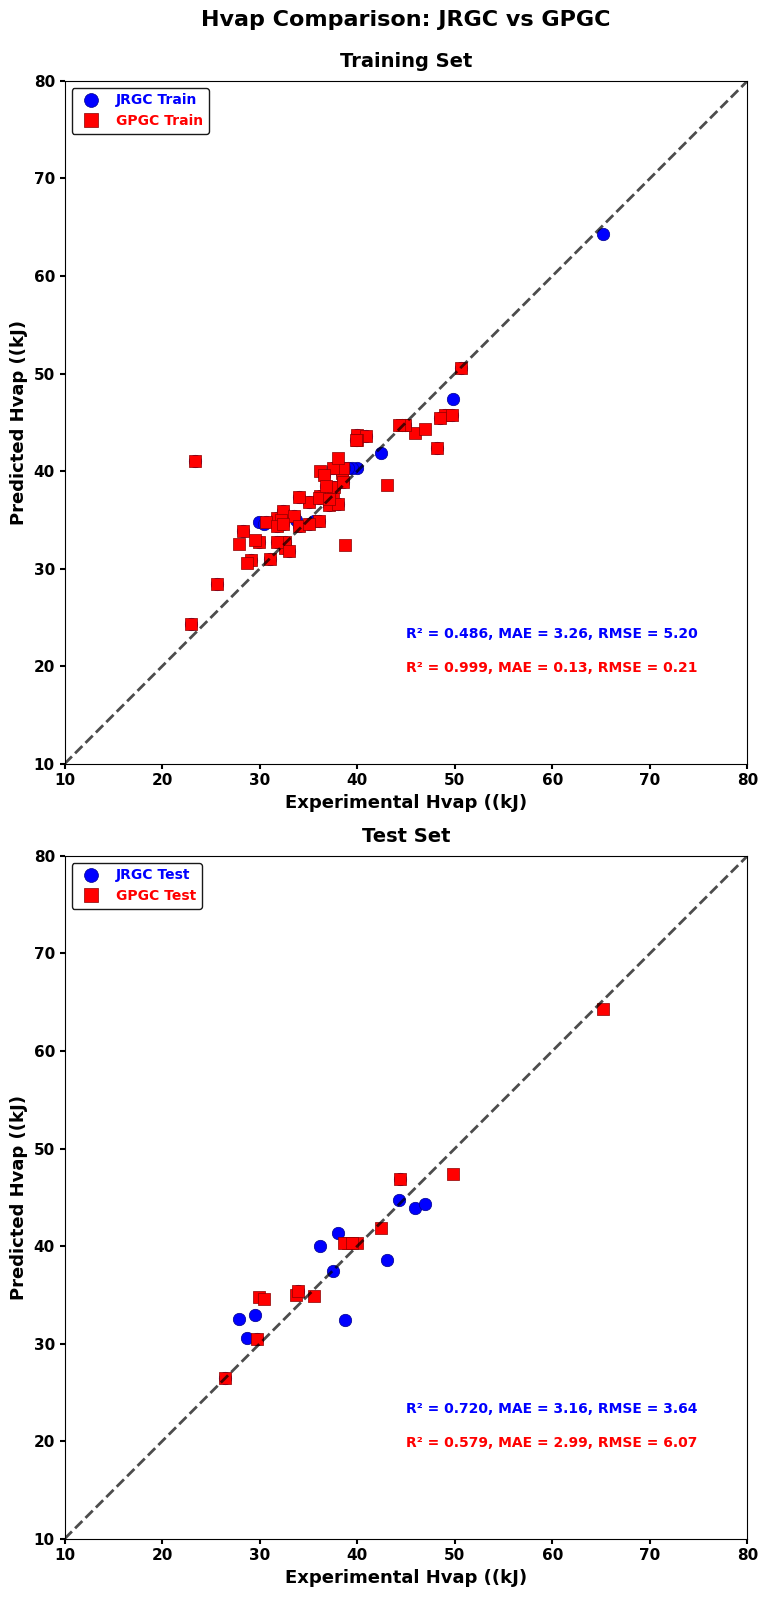


Dataset Summary:
Dataset              Samples    Experimental Range             Predicted Range               
--------------------------------------------------------------------------------
JRGC Train           60         22.94 - 65.20 (kJ             6.74 - 82.89 (kJ
GPGC Train           60         22.94 - 50.60 (kJ             6.74 - 82.89 (kJ
JRGC Test            15         26.40 - 46.90 (kJ             26.48 - 46.91 (kJ
GPGC Test            15         26.40 - 65.20 (kJ             26.48 - 64.29 (kJ

Axis ranges used:
X-axis (Experimental): 10.00 - 80.00 (kJ
Y-axis (Predicted): 10.00 - 80.00 (kJ

Plots saved to: /content/drive/Shareddrives/GCCP/GCCP/Output_files/data_Plots/
Total files saved: 3

Saved file paths:
  - /content/drive/Shareddrives/GCCP/GCCP/Output_files/data_Plots/Hvap_GRvsGP.png
  - /content/drive/Shareddrives/GCCP/GCCP/Output_files/data_Plots/Hvap_GRvsGP.pdf
  - /content/drive/Shareddrives/GCCP/GCCP/Output_files/data_Plots/Hvap_GRvsGP.eps


In [ ]:
# Example usage
property_name = 'Hvap'  # Define property name first

result = plotCombinedTrainTestComparison(
    property_name=property_name,
    jrgc_train_path=outputDir + f'/JRGC/JRGC_train_{property_name}.csv',
    jrgc_test_path=outputDir + f'/JRGC/JRGC_test_{property_name}.csv',
    gpgc_train_path=outputDir + f'/{property_name}/model_4/train_data.csv',
    gpgc_test_path=outputDir + f'/{property_name}/model_4/test_data.csv',
    jrgc_train_stats={'R2': 0.486, 'MAE': 3.261, 'RMSE': 5.202},
    gpgc_train_stats={'R2': 0.999, 'MAE': 0.13, 'RMSE': 0.21},
    jrgc_test_stats={'R2': 0.720, 'MAE': 3.157, 'RMSE': 3.639},
    gpgc_test_stats={'R2': 0.579, 'MAE': 2.99, 'RMSE': 6.07},
    x_range=(10, 80),  # X-axis (Experimental) range
    y_range=(10, 80),  # Y-axis (Predicted) range
    savePlotDir=savePlotDir
)

# Access saved file paths
print("\nSaved file paths:")
for file_path in result['saved_files']:
    print(f"  - {file_path}")

# Pc

 PNG saved: /content/drive/Shareddrives/GCCP/GCCP/Output_files/data_Plots/Pc_GRvsGP.png


 PDF saved: /content/drive/Shareddrives/GCCP/GCCP/Output_files/data_Plots/Pc_GRvsGP.pdf
 EPS saved: /content/drive/Shareddrives/GCCP/GCCP/Output_files/data_Plots/Pc_GRvsGP.eps


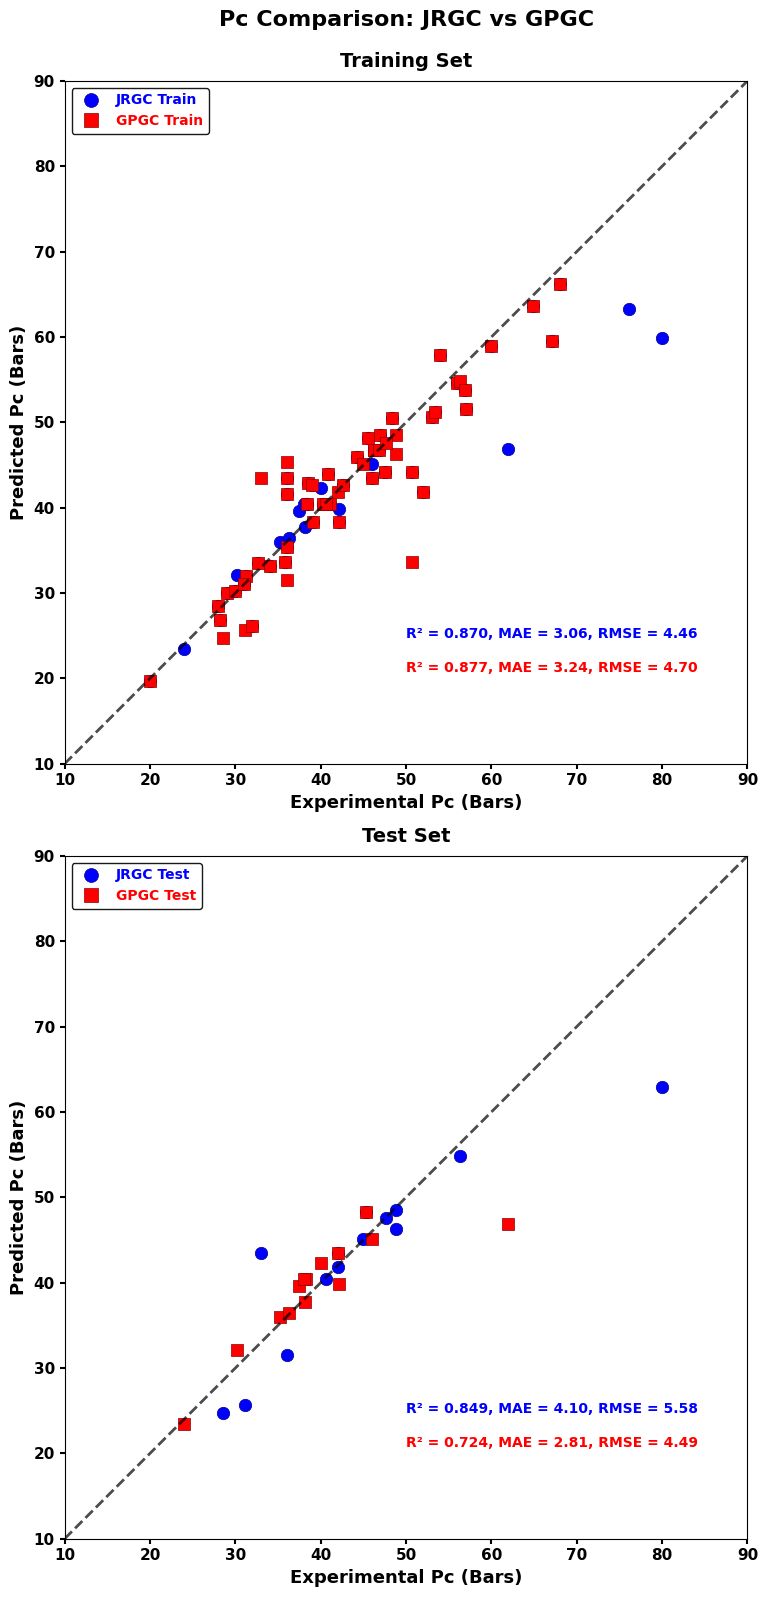


Dataset Summary:
Dataset              Samples    Experimental Range             Predicted Range               
--------------------------------------------------------------------------------
JRGC Train           58         20.00 - 80.00 Bars            19.65 - 66.21 Bars
GPGC Train           57         20.00 - 68.00 Bars            19.65 - 66.21 Bars
JRGC Test            15         12.40 - 80.00 Bars            8.86 - 62.89 Bars
GPGC Test            14         24.00 - 62.00 Bars            23.47 - 48.23 Bars

Axis ranges used:
X-axis (Experimental): 10.00 - 90.00 Bars
Y-axis (Predicted): 10.00 - 90.00 Bars

Plots saved to: /content/drive/Shareddrives/GCCP/GCCP/Output_files/data_Plots/
Total files saved: 3

Saved file paths:
  - /content/drive/Shareddrives/GCCP/GCCP/Output_files/data_Plots/Pc_GRvsGP.png
  - /content/drive/Shareddrives/GCCP/GCCP/Output_files/data_Plots/Pc_GRvsGP.pdf
  - /content/drive/Shareddrives/GCCP/GCCP/Output_files/data_Plots/Pc_GRvsGP.eps


In [ ]:
# Example usage
property_name = 'Pc'  # Define property name first

result = plotCombinedTrainTestComparison(
    property_name=property_name,
    jrgc_train_path=outputDir + f'/JRGC/JRGC_train_{property_name}.csv',
    jrgc_test_path=outputDir + f'/JRGC/JRGC_test_{property_name}.csv',
    gpgc_train_path=outputDir + f'/{property_name}/model_4/train_data.csv',
    gpgc_test_path=outputDir + f'/{property_name}/model_4/test_data.csv',
    jrgc_train_stats={'R2': 0.870, 'MAE': 3.063, 'RMSE': 4.458},
    gpgc_train_stats={'R2': 0.877, 'MAE': 3.242, 'RMSE': 4.703},
    jrgc_test_stats={'R2': 0.849, 'MAE': 4.098, 'RMSE': 5.578},
    gpgc_test_stats={'R2': 0.724, 'MAE': 2.815, 'RMSE': 4.494},
    x_range=(10, 90),  # X-axis (Experimental) range
    y_range=(10, 90),  # Y-axis (Predicted) range
    savePlotDir=savePlotDir
)

# Access saved file paths
print("\nSaved file paths:")
for file_path in result['saved_files']:
    print(f"  - {file_path}")

# Vc

 PNG saved: /content/drive/Shareddrives/GCCP/GCCP/Output_files/data_Plots/Vc_GRvsGP.png


 PDF saved: /content/drive/Shareddrives/GCCP/GCCP/Output_files/data_Plots/Vc_GRvsGP.pdf
 EPS saved: /content/drive/Shareddrives/GCCP/GCCP/Output_files/data_Plots/Vc_GRvsGP.eps


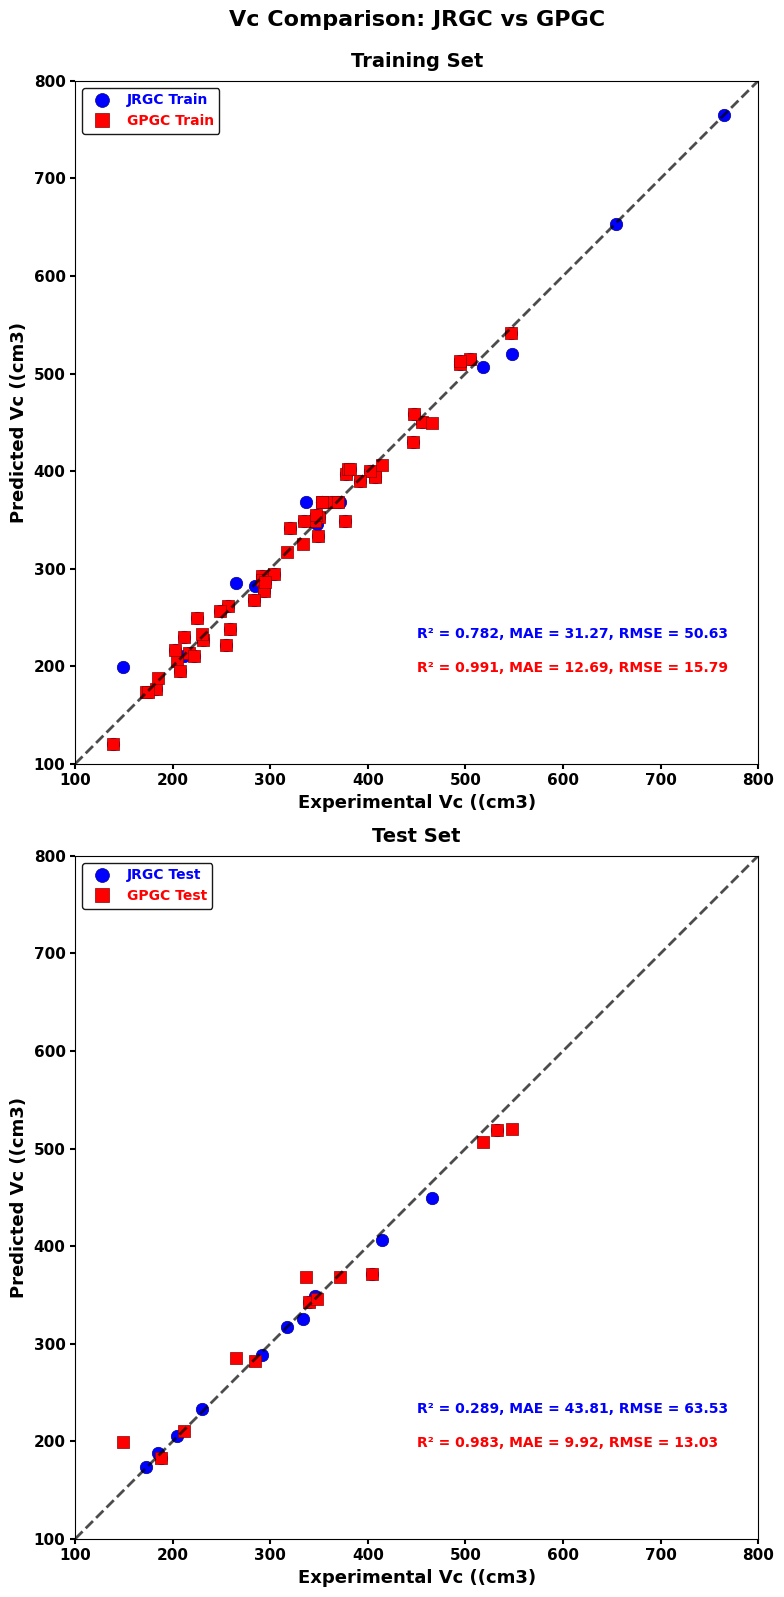


Dataset Summary:
Dataset              Samples    Experimental Range             Predicted Range               
--------------------------------------------------------------------------------
JRGC Train           55         139.00 - 1196.00 (cm3            120.50 - 1079.50 (cm3
GPGC Train           53         139.00 - 547.00 (cm3            120.50 - 541.50 (cm3
JRGC Test            14         173.00 - 532.00 (cm3            173.50 - 518.50 (cm3
GPGC Test            13         149.00 - 548.00 (cm3            182.50 - 520.50 (cm3

Axis ranges used:
X-axis (Experimental): 100.00 - 800.00 (cm3
Y-axis (Predicted): 100.00 - 800.00 (cm3

Plots saved to: /content/drive/Shareddrives/GCCP/GCCP/Output_files/data_Plots/
Total files saved: 3

Saved file paths:
  - /content/drive/Shareddrives/GCCP/GCCP/Output_files/data_Plots/Vc_GRvsGP.png
  - /content/drive/Shareddrives/GCCP/GCCP/Output_files/data_Plots/Vc_GRvsGP.pdf
  - /content/drive/Shareddrives/GCCP/GCCP/Output_files/data_Plots/Vc_GRvsGP.eps


In [ ]:
# Example usage
property_name = 'Vc'  # Define property name first

result = plotCombinedTrainTestComparison(
    property_name=property_name,
    jrgc_train_path=outputDir + f'/JRGC/JRGC_train_{property_name}.csv',
    jrgc_test_path=outputDir + f'/JRGC/JRGC_test_{property_name}.csv',
    gpgc_train_path=outputDir + f'/{property_name}/model_4/train_data.csv',
    gpgc_test_path=outputDir + f'/{property_name}/model_4/test_data.csv',
    jrgc_train_stats={'R2': 0.782, 'MAE': 31.273, 'RMSE': 50.629},
    gpgc_train_stats={'R2': 0.991, 'MAE': 12.688, 'RMSE': 15.792},
    jrgc_test_stats={'R2': 0.289, 'MAE': 43.808, 'RMSE': 63.532},
    gpgc_test_stats={'R2': 0.983, 'MAE': 9.924, 'RMSE': 13.028},
    x_range=(100, 800),  # X-axis (Experimental) range
    y_range=(100, 800),  # Y-axis (Predicted) range
    savePlotDir=savePlotDir
)

# Access saved file paths
print("\nSaved file paths:")
for file_path in result['saved_files']:
    print(f"  - {file_path}")

# Tc

 PNG saved: /content/drive/Shareddrives/GCCP/GCCP/Output_files/data_Plots/Tc_GRvsGP.png


 PDF saved: /content/drive/Shareddrives/GCCP/GCCP/Output_files/data_Plots/Tc_GRvsGP.pdf
 EPS saved: /content/drive/Shareddrives/GCCP/GCCP/Output_files/data_Plots/Tc_GRvsGP.eps


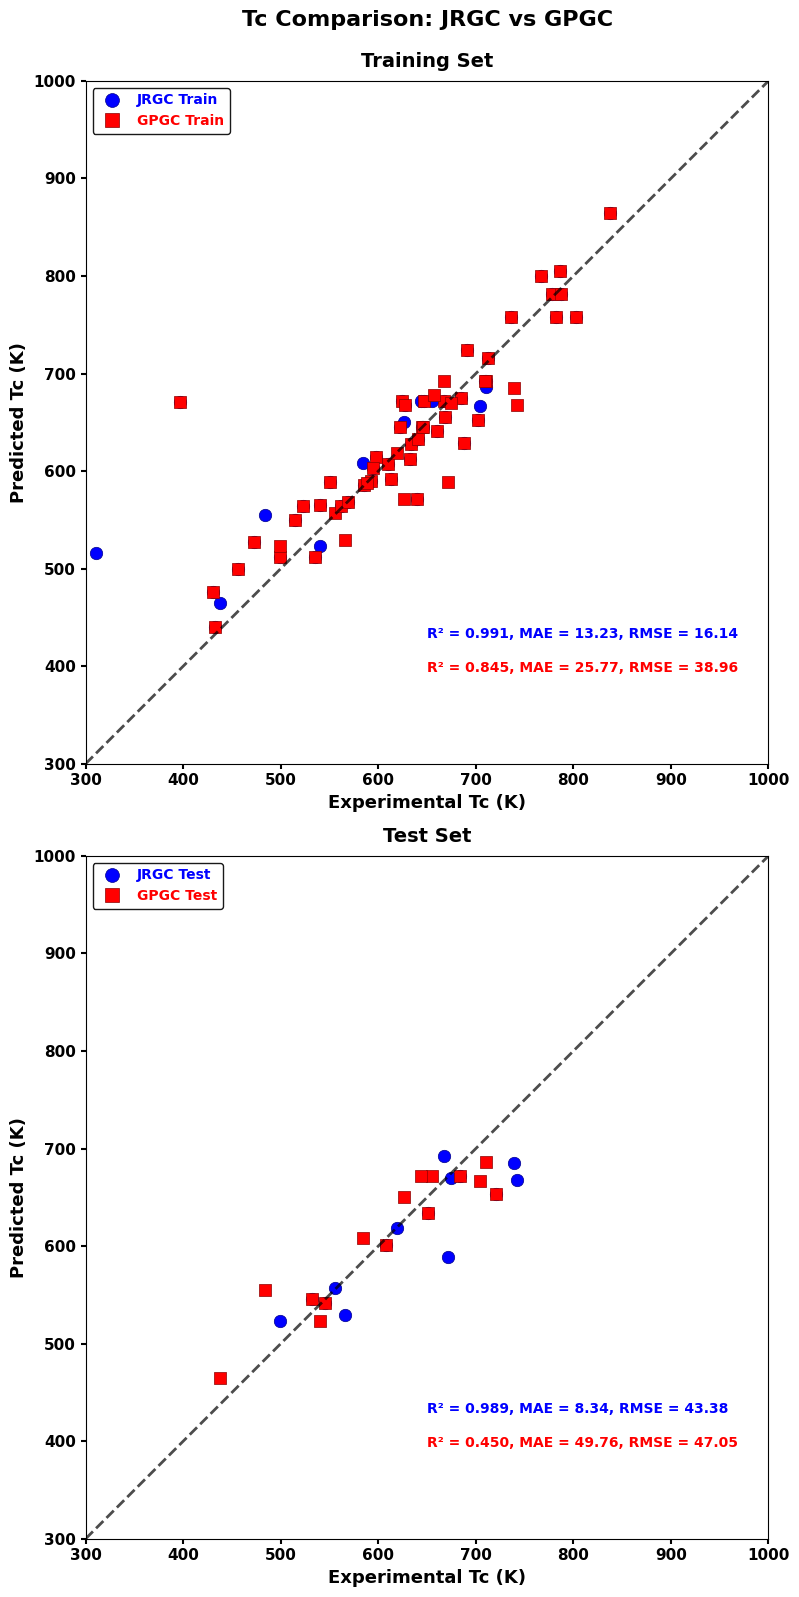


Dataset Summary:
Dataset              Samples    Experimental Range             Predicted Range               
--------------------------------------------------------------------------------
JRGC Train           58         311.10 - 838.00 K               440.20 - 864.10 K
GPGC Train           59         397.00 - 838.00 K               440.20 - 864.10 K
JRGC Test            15         499.20 - 742.00 K               522.87 - 692.10 K
GPGC Test            15         437.50 - 721.00 K               464.41 - 686.26 K

Axis ranges used:
X-axis (Experimental): 300.00 - 1000.00 K
Y-axis (Predicted): 300.00 - 1000.00 K

Plots saved to: /content/drive/Shareddrives/GCCP/GCCP/Output_files/data_Plots/
Total files saved: 3

Saved file paths:
  - /content/drive/Shareddrives/GCCP/GCCP/Output_files/data_Plots/Tc_GRvsGP.png
  - /content/drive/Shareddrives/GCCP/GCCP/Output_files/data_Plots/Tc_GRvsGP.pdf
  - /content/drive/Shareddrives/GCCP/GCCP/Output_files/data_Plots/Tc_GRvsGP.eps


In [ ]:
# Example usage
property_name = 'Tc'  # Define property name first

result = plotCombinedTrainTestComparison(
    property_name=property_name,
    jrgc_train_path=outputDir + f'/JRGC/JRGC_train_{property_name}.csv',
    jrgc_test_path=outputDir + f'/JRGC/JRGC_test_{property_name}.csv',
    gpgc_train_path=outputDir + f'/{property_name}/model_4/train_data.csv',
    gpgc_test_path=outputDir + f'/{property_name}/model_4/test_data.csv',
    jrgc_train_stats={'R2': 0.991, 'MAE': 13.233, 'RMSE': 16.135},
    gpgc_train_stats={'R2': 0.845, 'MAE': 25.775, 'RMSE': 38.964},
    jrgc_test_stats={'R2': 0.989, 'MAE': 8.335, 'RMSE': 43.38},
    gpgc_test_stats={'R2': 0.45, 'MAE': 49.756, 'RMSE': 47.05},
    x_range=(300, 1000),  # X-axis (Experimental) range
    y_range=(300, 1000),  # Y-axis (Predicted) range
    savePlotDir=savePlotDir
)

# Access saved file paths
print("\nSaved file paths:")
for file_path in result['saved_files']:
    print(f"  - {file_path}")

# logP

 PNG saved: /content/drive/Shareddrives/GCCP/GCCP/Output_files/data_Plots/logP_GRvsGP.png


 PDF saved: /content/drive/Shareddrives/GCCP/GCCP/Output_files/data_Plots/logP_GRvsGP.pdf
 EPS saved: /content/drive/Shareddrives/GCCP/GCCP/Output_files/data_Plots/logP_GRvsGP.eps


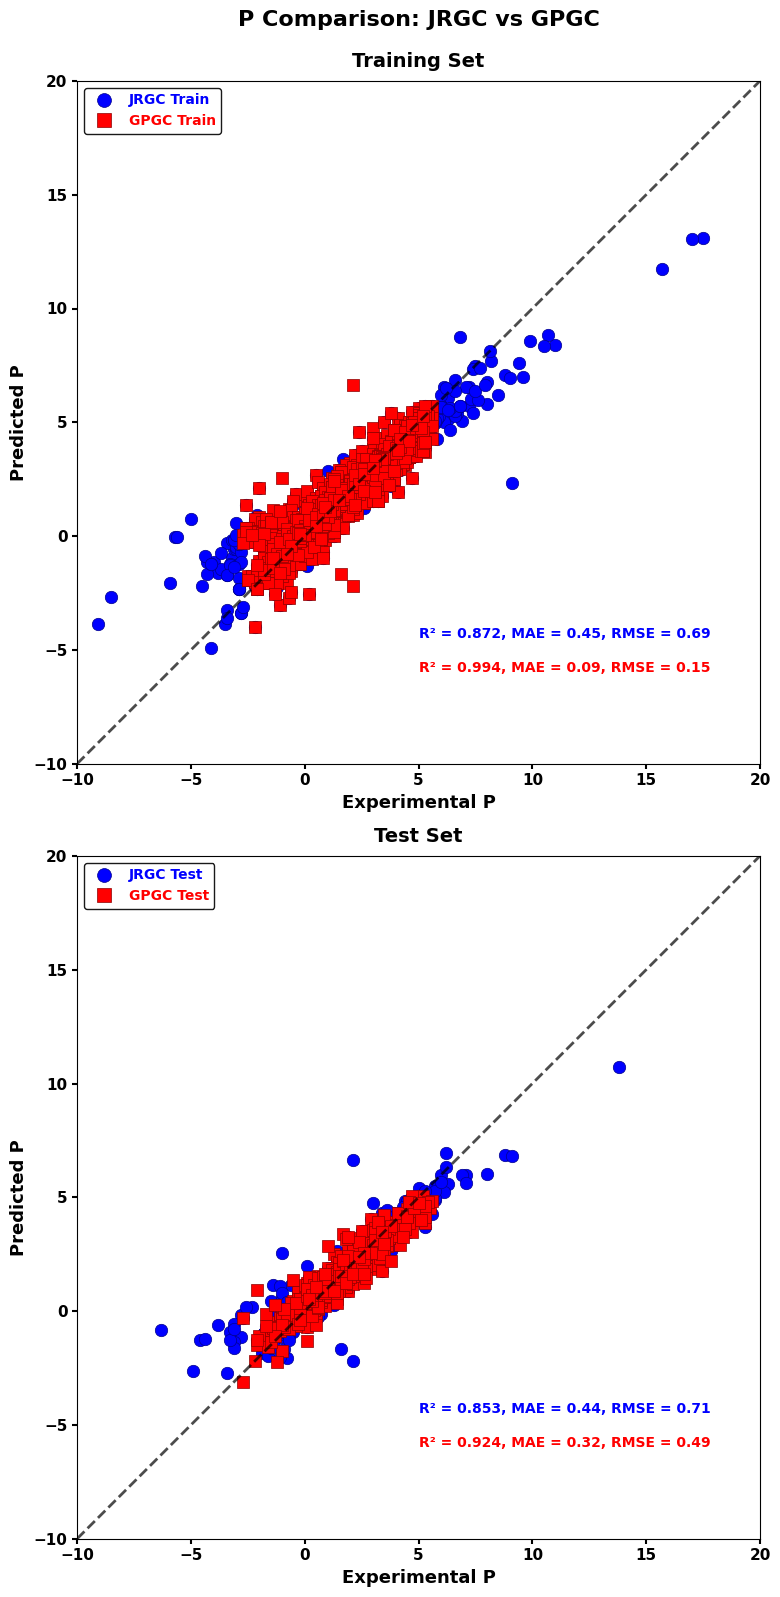


Dataset Summary:
Dataset              Samples    Experimental Range             Predicted Range               
--------------------------------------------------------------------------------
JRGC Train           2770       -9.10 - 17.50                 -4.90 - 13.10 
GPGC Train           2655       -2.70 - 5.60                 -4.01 - 6.63 
JRGC Test            693        -6.30 - 13.80                 -2.74 - 10.71 
GPGC Test            664        -2.70 - 5.60                 -3.11 - 5.07 

Axis ranges used:
X-axis (Experimental): -10.00 - 20.00 
Y-axis (Predicted): -10.00 - 20.00 

Plots saved to: /content/drive/Shareddrives/GCCP/GCCP/Output_files/data_Plots/
Total files saved: 3

Saved file paths:
  - /content/drive/Shareddrives/GCCP/GCCP/Output_files/data_Plots/logP_GRvsGP.png
  - /content/drive/Shareddrives/GCCP/GCCP/Output_files/data_Plots/logP_GRvsGP.pdf
  - /content/drive/Shareddrives/GCCP/GCCP/Output_files/data_Plots/logP_GRvsGP.eps


In [ ]:
# Example usage
property_name = 'logP'  # Define property name first

result = plotCombinedTrainTestComparison(
    property_name=property_name,
    jrgc_train_path=outputDir + f'/JRGC/JRGC_train_{property_name}.csv',
    jrgc_test_path=outputDir + f'/JRGC/JRGC_test_{property_name}.csv',
    gpgc_train_path=outputDir + f'/{property_name}/model_4/train_data.csv',
    gpgc_test_path=outputDir + f'/{property_name}/model_4/test_data.csv',
    jrgc_train_stats={'R2': 0.872, 'MAE': 0.454, 'RMSE': 0.695},
    gpgc_train_stats={'R2': 0.994, 'MAE': 0.089, 'RMSE': 0.147},
    jrgc_test_stats={'R2': 0.853, 'MAE': 0.444, 'RMSE': 0.713},
    gpgc_test_stats={'R2': 0.924, 'MAE': 0.316, 'RMSE': 0.495},
    x_range=(-10, 20),  # X-axis (Experimental) range
    y_range=(-10, 20),  # Y-axis (Predicted) range
    savePlotDir=savePlotDir
)

# Access saved file paths
print("\nSaved file paths:")
for file_path in result['saved_files']:
    print(f"  - {file_path}")

### Plot all properties in same plot (excluding Vc)

✓ Tb plotted successfully
✓ Tm plotted successfully
✓ logP plotted successfully
✓ Pc plotted successfully
✓ Tc plotted successfully
✓ Hvap plotted successfully
✓ PNG saved: /content/drive/Shareddrives/GCCP/GCCP/Output_files/data_Plots/All_Properties_TrainTest_Comparison.png
✓ PDF saved: /content/drive/Shareddrives/GCCP/GCCP/Output_files/data_Plots/All_Properties_TrainTest_Comparison.pdf


✓ EPS saved: /content/drive/Shareddrives/GCCP/GCCP/Output_files/data_Plots/All_Properties_TrainTest_Comparison.eps


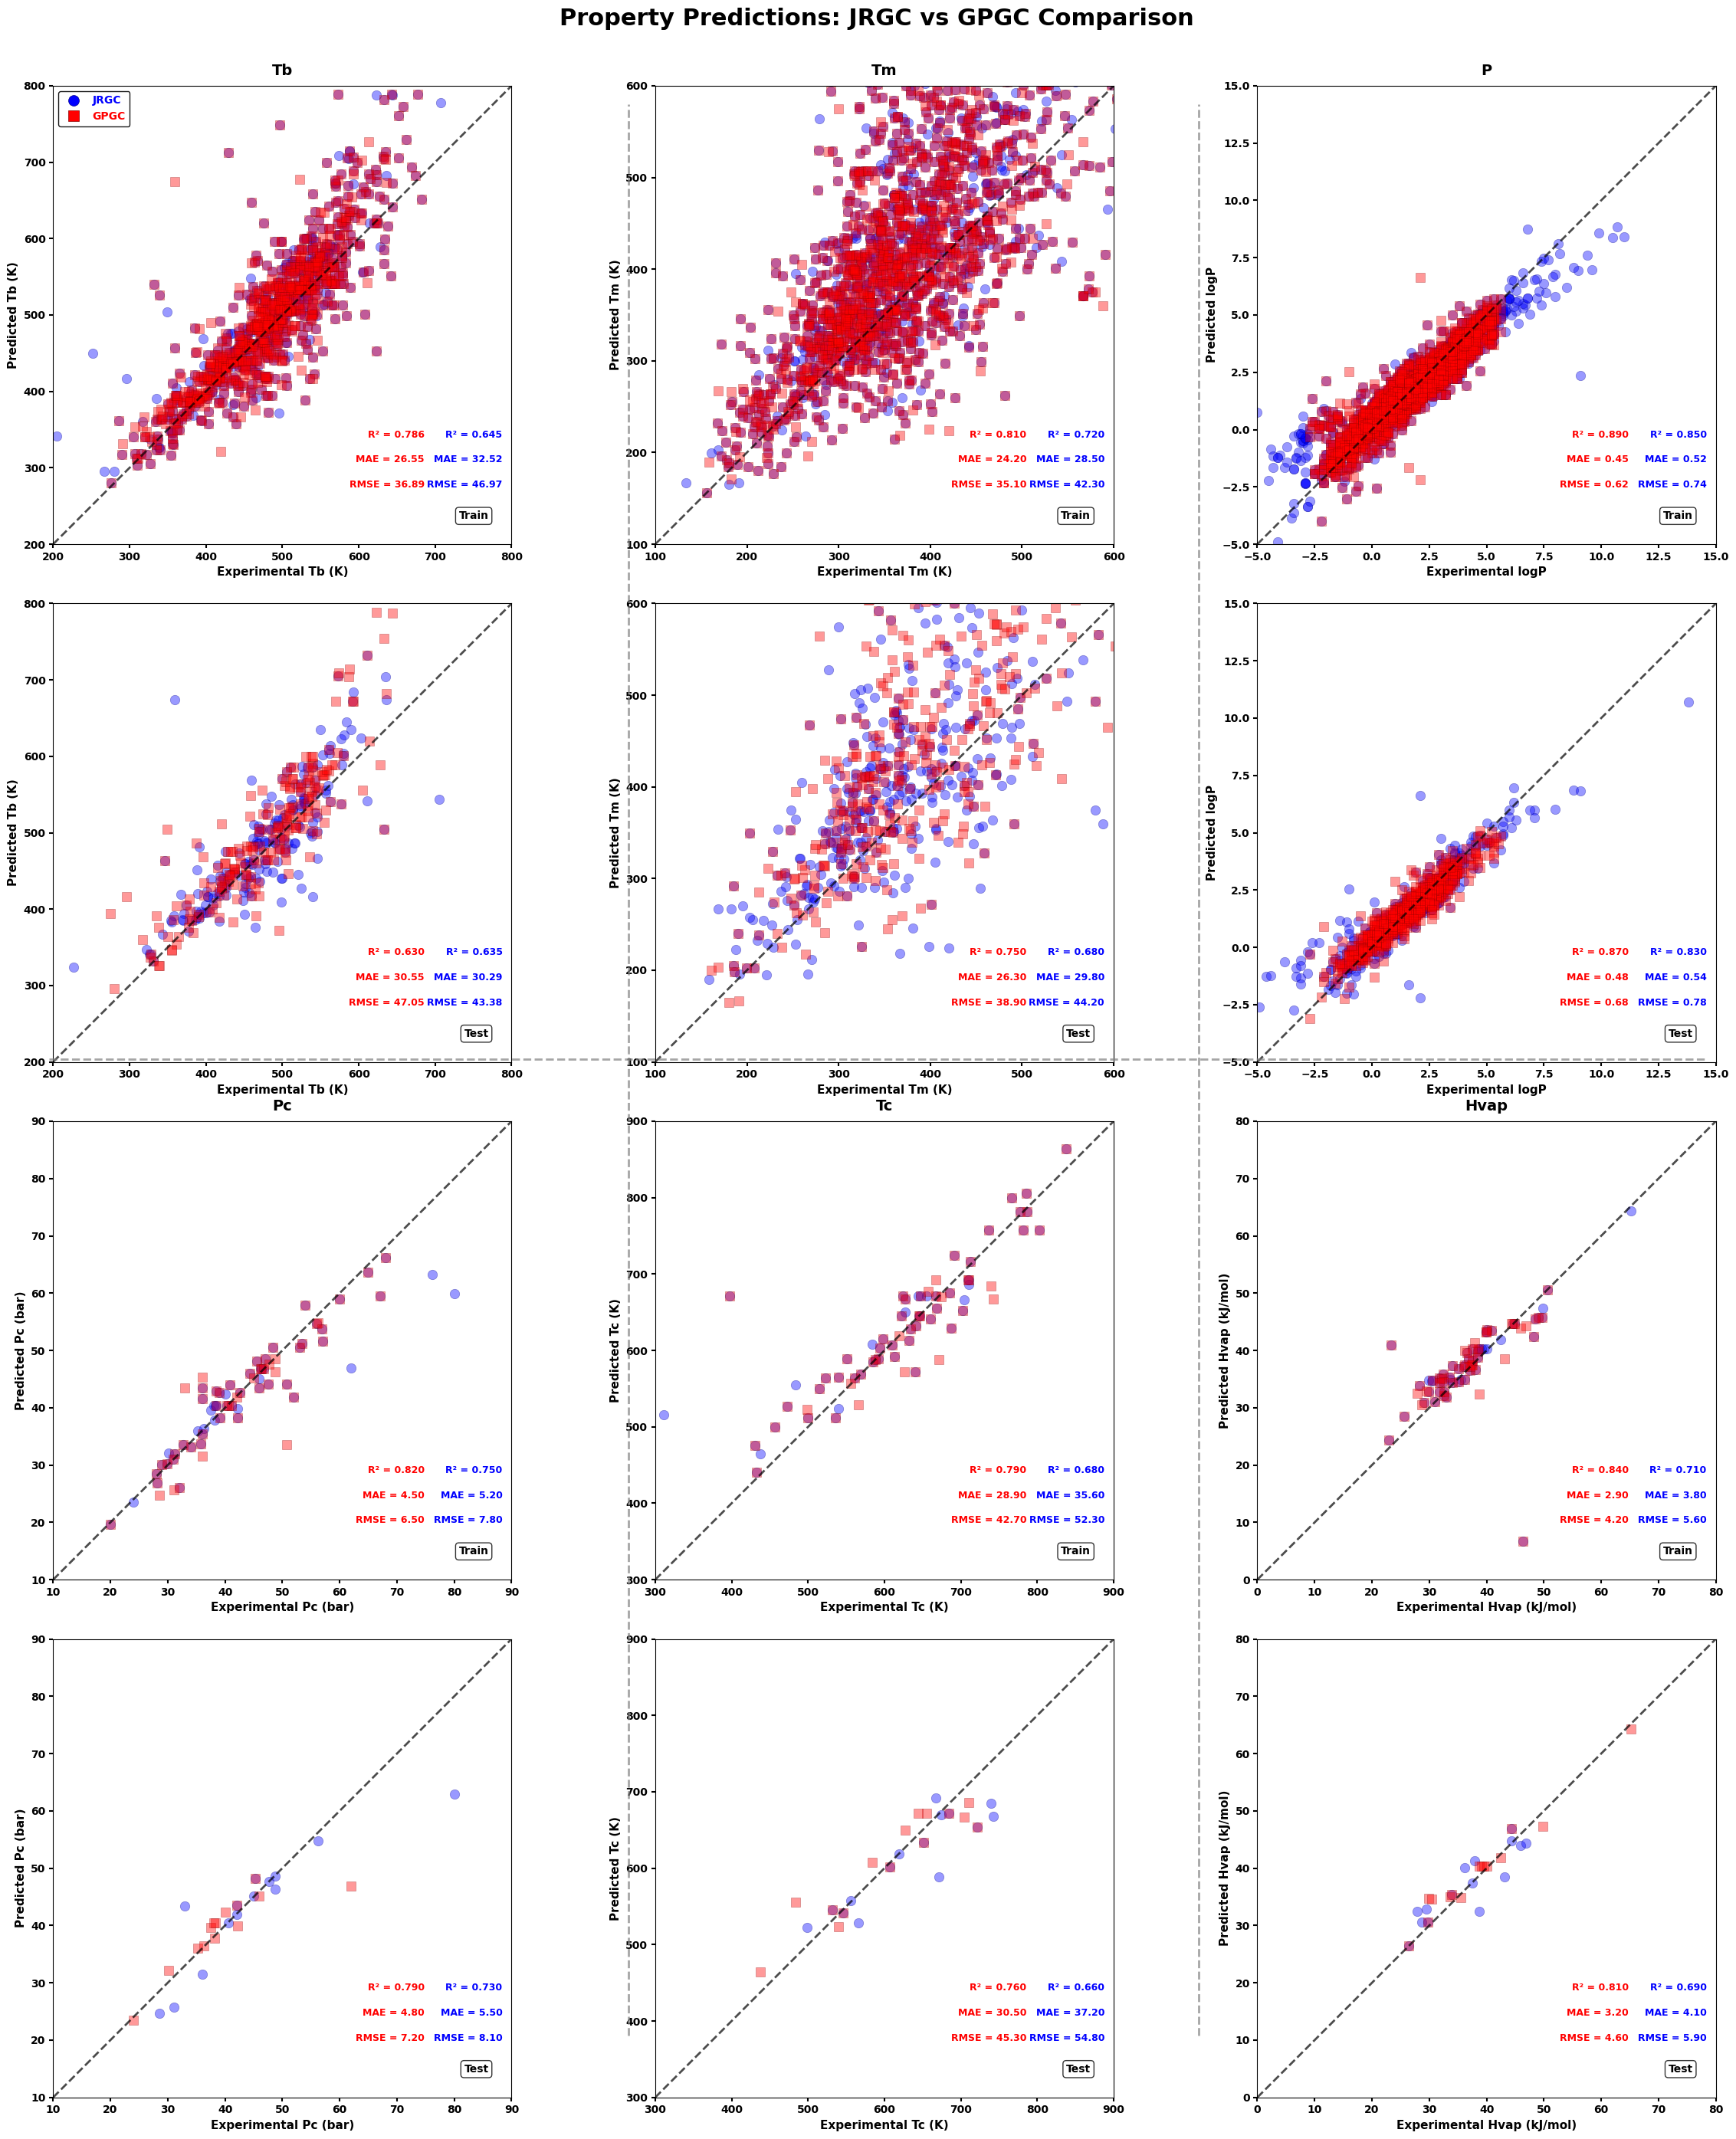


All saved file paths:
  - /content/drive/Shareddrives/GCCP/GCCP/Output_files/data_Plots/All_Properties_TrainTest_Comparison.png
  - /content/drive/Shareddrives/GCCP/GCCP/Output_files/data_Plots/All_Properties_TrainTest_Comparison.pdf
  - /content/drive/Shareddrives/GCCP/GCCP/Output_files/data_Plots/All_Properties_TrainTest_Comparison.eps


In [ ]:
# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

def parsePropertyInfo(predicted_col, experimental_col):
    """Extract property name and unit from column headers"""
    # Extract property name (assumes format like "JR Tb /K" or "Method PropertyName /Unit")
    pred_parts = predicted_col.split()
    exp_parts = experimental_col.split()

    # Try to extract property name and unit
    pred_method = pred_parts[0] if len(pred_parts) > 0 else "Predicted"
    exp_method = exp_parts[0] if len(exp_parts) > 0 else "Experimental"

    # Extract property name (middle part)
    if len(pred_parts) >= 2:
        property_name = pred_parts[1]
    else:
        property_name = "Property"

    # Extract unit (part after /)
    pred_unit = ""
    exp_unit = ""

    for part in pred_parts:
        if "/" in part:
            pred_unit = part.split("/")[-1]
            break

    for part in exp_parts:
        if "/" in part:
            exp_unit = part.split("/")[-1]
            break

    # Use the same unit for both (prefer experimental)
    unit = exp_unit if exp_unit else pred_unit

    # Clean up property name
    property_name_clean = property_name.replace("_", " ").title()

    return {
        'property_name': property_name_clean,
        'unit': unit,
        'pred_method': pred_method,
        'exp_method': exp_method,
        'full_property_name': f"{property_name_clean} ({unit})" if unit else property_name_clean
    }

def plotAllPropertiesTrainTestComparison(properties_config, outputDir, savePlotDir):
    """
    Plot all properties in a 4x3 subplot grid (Train/Test separated)
    Row 1: Tb, Tm, logP (Train)
    Row 2: Tb, Tm, logP (Test)
    Row 3: Pc, Tc, Hvap (Train)
    Row 4: Pc, Tc, Hvap (Test)

    Parameters:
    -----------
    properties_config : list of dict
        List of dictionaries, each containing:
        - 'property_name': str (e.g., 'Tb', 'Tm', etc.)
        - 'jrgc_train_stats': dict with 'R2', 'MAE', 'RMSE'
        - 'gpgc_train_stats': dict with 'R2', 'MAE', 'RMSE'
        - 'jrgc_test_stats': dict with 'R2', 'MAE', 'RMSE'
        - 'gpgc_test_stats': dict with 'R2', 'MAE', 'RMSE'
        - 'x_range': tuple (min, max) for x-axis
        - 'y_range': tuple (min, max) for y-axis
        - 'x_label': str, custom x-axis label (optional)
        - 'y_label': str, custom y-axis label (optional)
    outputDir : str
        Base directory for data files
    savePlotDir : str
        Directory to save the combined plot
    """

    # Create figure with 4 rows and 3 columns
    fig, axes = plt.subplots(4, 3, figsize=(24, 28))
    fig.suptitle('Property Predictions: JRGC vs GPGC Comparison',
                 fontsize=22, fontweight='bold', y=0.995)

    # Define property order
    # First 3 properties (Tb, Tm, logP) go in rows 0-1
    # Last 3 properties (Pc, Tc, Hvap) go in rows 2-3

    # Process each property
    for prop_idx, config in enumerate(properties_config):
        if prop_idx >= 6:  # Only 6 properties
            break

        property_name = config['property_name']

        # Determine column and row positions
        if prop_idx < 3:  # First 3 properties (Tb, Tm, logP)
            col = prop_idx
            train_row = 0
            test_row = 1
        else:  # Last 3 properties (Pc, Tc, Hvap)
            col = prop_idx - 3
            train_row = 2
            test_row = 3

        # Get axes for train and test
        ax_train = axes[train_row, col]
        ax_test = axes[test_row, col]

        # Construct file paths
        jrgc_train_path = outputDir + f'/JRGC/JRGC_train_{property_name}.csv'
        jrgc_test_path = outputDir + f'/JRGC/JRGC_test_{property_name}.csv'
        gpgc_train_path = outputDir + f'/{property_name}/model_4/train_data.csv'
        gpgc_test_path = outputDir + f'/{property_name}/model_4/test_data.csv'

        try:
            # Read the CSV files
            jrgc_train = pd.read_csv(jrgc_train_path)
            gpgc_train = pd.read_csv(gpgc_train_path)
            jrgc_test = pd.read_csv(jrgc_test_path)
            gpgc_test = pd.read_csv(gpgc_test_path)

            # Get the last two columns (predicted and experimental)
            jrgc_train_pred = jrgc_train.iloc[:, -2]
            jrgc_train_exp = jrgc_train.iloc[:, -1]
            gpgc_train_pred = gpgc_train.iloc[:, -2]
            gpgc_train_exp = gpgc_train.iloc[:, -1]

            jrgc_test_pred = jrgc_test.iloc[:, -2]
            jrgc_test_exp = jrgc_test.iloc[:, -1]
            gpgc_test_pred = gpgc_test.iloc[:, -2]
            gpgc_test_exp = gpgc_test.iloc[:, -1]

            # Get column names for labels
            pred_col_name = jrgc_train.columns[-2]
            exp_col_name = jrgc_train.columns[-1]

            # Parse property info
            prop_info = parsePropertyInfo(pred_col_name, exp_col_name)

            # Get custom axis labels from config or use defaults
            x_label = config.get('x_label', f'Experimental {prop_info["full_property_name"]}')
            y_label = config.get('y_label', f'Predicted {prop_info["full_property_name"]}')

            # Get axis ranges from config (REQUIRED)
            x_range = config.get('x_range')
            y_range = config.get('y_range')

            # Use provided ranges or auto-calculate if not provided
            if x_range is None or y_range is None:
                all_pred = pd.concat([jrgc_train_pred, gpgc_train_pred, jrgc_test_pred, gpgc_test_pred])
                all_exp = pd.concat([jrgc_train_exp, gpgc_train_exp, jrgc_test_exp, gpgc_test_exp])

                if x_range is None:
                    minVal_x = all_exp.min()
                    maxVal_x = all_exp.max()
                    padding_x = (maxVal_x - minVal_x) * 0.05
                    x_range = (minVal_x - padding_x, maxVal_x + padding_x)

                if y_range is None:
                    minVal_y = all_pred.min()
                    maxVal_y = all_pred.max()
                    padding_y = (maxVal_y - minVal_y) * 0.05
                    y_range = (minVal_y - padding_y, maxVal_y + padding_y)

            minVal_x, maxVal_x = x_range
            minVal_y, maxVal_y = y_range

            parity_min = min(minVal_x, minVal_y)
            parity_max = max(maxVal_x, maxVal_y)

            # ========== PLOT TRAIN DATA ==========
            # Plot JRGC train data (Blue, circle markers)
            ax_train.scatter(jrgc_train_exp, jrgc_train_pred,
                           alpha=0.4, s=80, c='blue', marker='o',
                           edgecolors='darkblue', linewidths=0.5,
                           label='JRGC')

            # Plot GPGC train data (Red, square markers)
            ax_train.scatter(gpgc_train_exp, gpgc_train_pred,
                           alpha=0.4, s=80, c='red', marker='s',
                           edgecolors='darkred', linewidths=0.5,
                           label='GPGC')

            # Perfect parity line
            ax_train.plot([parity_min, parity_max], [parity_min, parity_max],
                         'k--', alpha=0.7, linewidth=2)

            # Set title (property name) only for train row
            ax_train.set_title(f'{prop_info["property_name"]}',
                             fontsize=14, fontweight='bold', pad=10)

            # Set labels on all subplots
            ax_train.set_xlabel(x_label, fontsize=11, fontweight='bold')
            ax_train.set_ylabel(y_label, fontsize=11, fontweight='bold')

            ax_train.set_xlim(minVal_x, maxVal_x)
            ax_train.set_ylim(minVal_y, maxVal_y)
            ax_train.set_aspect('equal', adjustable='box')

            # Make tick labels bold
            ax_train.tick_params(axis='both', which='major', labelsize=10, width=1.5)
            for label in ax_train.get_xticklabels() + ax_train.get_yticklabels():
                label.set_fontweight('bold')

            # Add "Train" label inside the plot
            ax_train.text(0.95, 0.05, 'Train',
                         transform=ax_train.transAxes, fontsize=10,
                         fontweight='bold', verticalalignment='bottom',
                         horizontalalignment='right',
                         bbox=dict(boxstyle='round', facecolor='white',
                                 alpha=0.8, edgecolor='black'))

            # Add legend (only for first train plot)
            if prop_idx == 0:
                legend_elements = [
                    plt.Line2D([0], [0], marker='o', color='w',
                              markerfacecolor='blue', markeredgecolor='darkblue',
                              markersize=10, markeredgewidth=0.5, label='JRGC'),
                    plt.Line2D([0], [0], marker='s', color='w',
                              markerfacecolor='red', markeredgecolor='darkred',
                              markersize=10, markeredgewidth=0.5, label='GPGC'),
                ]

                legend_train = ax_train.legend(handles=legend_elements, loc='upper left',
                                              framealpha=0.9, edgecolor='black',
                                              prop={'size': 10, 'weight': 'bold'})

                # Set text colors
                legend_train.get_texts()[0].set_color('blue')
                legend_train.get_texts()[1].set_color('red')

            # Add statistics for training (3 rows, right bottom corner)
            stats_y_start = 0.25  # Starting y position
            stats_x_jrgc = 0.98  # Right side for JRGC
            stats_x_gpgc = 0.81  # Slightly left for GPGC
            line_spacing = 0.055

            if config.get('jrgc_train_stats'):
                stats = config['jrgc_train_stats']
                ax_train.text(stats_x_jrgc, stats_y_start, f"R² = {stats.get('R2', 0):.3f}",
                            transform=ax_train.transAxes, fontsize=9,
                            color='blue', fontweight='bold',
                            verticalalignment='top', horizontalalignment='right')
                ax_train.text(stats_x_jrgc, stats_y_start - line_spacing, f"MAE = {stats.get('MAE', 0):.2f}",
                            transform=ax_train.transAxes, fontsize=9,
                            color='blue', fontweight='bold',
                            verticalalignment='top', horizontalalignment='right')
                ax_train.text(stats_x_jrgc, stats_y_start - 2*line_spacing, f"RMSE = {stats.get('RMSE', 0):.2f}",
                            transform=ax_train.transAxes, fontsize=9,
                            color='blue', fontweight='bold',
                            verticalalignment='top', horizontalalignment='right')

            if config.get('gpgc_train_stats'):
                stats = config['gpgc_train_stats']
                ax_train.text(stats_x_gpgc, stats_y_start, f"R² = {stats.get('R2', 0):.3f}",
                            transform=ax_train.transAxes, fontsize=9,
                            color='red', fontweight='bold',
                            verticalalignment='top', horizontalalignment='right')
                ax_train.text(stats_x_gpgc, stats_y_start - line_spacing, f"MAE = {stats.get('MAE', 0):.2f}",
                            transform=ax_train.transAxes, fontsize=9,
                            color='red', fontweight='bold',
                            verticalalignment='top', horizontalalignment='right')
                ax_train.text(stats_x_gpgc, stats_y_start - 2*line_spacing, f"RMSE = {stats.get('RMSE', 0):.2f}",
                            transform=ax_train.transAxes, fontsize=9,
                            color='red', fontweight='bold',
                            verticalalignment='top', horizontalalignment='right')

            # ========== PLOT TEST DATA ==========
            # Plot JRGC test data (Blue, circle markers)
            ax_test.scatter(jrgc_test_exp, jrgc_test_pred,
                          alpha=0.4, s=80, c='blue', marker='o',
                          edgecolors='darkblue', linewidths=0.5,
                          label='JRGC')

            # Plot GPGC test data (Red, square markers)
            ax_test.scatter(gpgc_test_exp, gpgc_test_pred,
                          alpha=0.4, s=80, c='red', marker='s',
                          edgecolors='darkred', linewidths=0.5,
                          label='GPGC')

            # Perfect parity line
            ax_test.plot([parity_min, parity_max], [parity_min, parity_max],
                        'k--', alpha=0.7, linewidth=2)

            # Set labels on all subplots
            ax_test.set_xlabel(x_label, fontsize=11, fontweight='bold')
            ax_test.set_ylabel(y_label, fontsize=11, fontweight='bold')

            ax_test.set_xlim(minVal_x, maxVal_x)
            ax_test.set_ylim(minVal_y, maxVal_y)
            ax_test.set_aspect('equal', adjustable='box')

            # Make tick labels bold
            ax_test.tick_params(axis='both', which='major', labelsize=10, width=1.5)
            for label in ax_test.get_xticklabels() + ax_test.get_yticklabels():
                label.set_fontweight('bold')

            # Add "Test" label inside the plot
            ax_test.text(0.95, 0.05, 'Test',
                        transform=ax_test.transAxes, fontsize=10,
                        fontweight='bold', verticalalignment='bottom',
                        horizontalalignment='right',
                        bbox=dict(boxstyle='round', facecolor='white',
                                alpha=0.8, edgecolor='black'))

            # Add statistics for test (3 rows, right bottom corner)
            if config.get('jrgc_test_stats'):
                stats = config['jrgc_test_stats']
                ax_test.text(stats_x_jrgc, stats_y_start, f"R² = {stats.get('R2', 0):.3f}",
                           transform=ax_test.transAxes, fontsize=9,
                           color='blue', fontweight='bold',
                           verticalalignment='top', horizontalalignment='right')
                ax_test.text(stats_x_jrgc, stats_y_start - line_spacing, f"MAE = {stats.get('MAE', 0):.2f}",
                           transform=ax_test.transAxes, fontsize=9,
                           color='blue', fontweight='bold',
                           verticalalignment='top', horizontalalignment='right')
                ax_test.text(stats_x_jrgc, stats_y_start - 2*line_spacing, f"RMSE = {stats.get('RMSE', 0):.2f}",
                           transform=ax_test.transAxes, fontsize=9,
                           color='blue', fontweight='bold',
                           verticalalignment='top', horizontalalignment='right')

            if config.get('gpgc_test_stats'):
                stats = config['gpgc_test_stats']
                ax_test.text(stats_x_gpgc, stats_y_start, f"R² = {stats.get('R2', 0):.3f}",
                           transform=ax_test.transAxes, fontsize=9,
                           color='red', fontweight='bold',
                           verticalalignment='top', horizontalalignment='right')
                ax_test.text(stats_x_gpgc, stats_y_start - line_spacing, f"MAE = {stats.get('MAE', 0):.2f}",
                           transform=ax_test.transAxes, fontsize=9,
                           color='red', fontweight='bold',
                           verticalalignment='top', horizontalalignment='right')
                ax_test.text(stats_x_gpgc, stats_y_start - 2*line_spacing, f"RMSE = {stats.get('RMSE', 0):.2f}",
                           transform=ax_test.transAxes, fontsize=9,
                           color='red', fontweight='bold',
                           verticalalignment='top', horizontalalignment='right')

            print(f"✓ {property_name} plotted successfully")

        except Exception as e:
            print(f"✗ Error plotting {property_name}: {e}")
            ax_train.text(0.5, 0.5, f'Error loading {property_name}\n{str(e)}',
                        ha='center', va='center', transform=ax_train.transAxes,
                        fontsize=10, color='red')
            ax_test.text(0.5, 0.5, f'Error loading {property_name}\n{str(e)}',
                       ha='center', va='center', transform=ax_test.transAxes,
                       fontsize=10, color='red')

    # Remove white space between plots
    plt.tight_layout(rect=[0, 0, 1, 0.99], h_pad=0.3, w_pad=0.3)

    # Add horizontal dashed line between different property groups (between row 1 and row 2)
    # This separates Tb/Tm/logP from Pc/Tc/Hvap
    fig.add_artist(plt.Line2D([0.05, 0.95], [0.505, 0.505],
                              transform=fig.transFigure,
                              color='gray', linewidth=2, linestyle='--', alpha=0.7))

    # Add vertical dashed lines between different properties (between columns)
    # Between column 0 and 1 (Tb/Pc and Tm/Tc)
    fig.add_artist(plt.Line2D([0.365, 0.365], [0.05, 0.95],
                              transform=fig.transFigure,
                              color='gray', linewidth=2, linestyle='--', alpha=0.7))

    # Between column 1 and 2 (Tm/Tc and logP/Hvap)
    fig.add_artist(plt.Line2D([0.675, 0.675], [0.05, 0.95],
                              transform=fig.transFigure,
                              color='gray', linewidth=2, linestyle='--', alpha=0.7))

    # Create output directory if it doesn't exist
    os.makedirs(savePlotDir, exist_ok=True)

    # Save in multiple formats
    saved_files = []
    base_filename = 'All_Properties_TrainTest_Comparison'

    try:
        png_path = os.path.join(savePlotDir, f'{base_filename}.png')
        plt.savefig(png_path, dpi=300, bbox_inches='tight', format='png')
        saved_files.append(png_path)
        print(f"✓ PNG saved: {png_path}")
    except Exception as e:
        print(f"✗ Error saving PNG: {e}")

    try:
        pdf_path = os.path.join(savePlotDir, f'{base_filename}.pdf')
        plt.savefig(pdf_path, bbox_inches='tight', format='pdf')
        saved_files.append(pdf_path)
        print(f"✓ PDF saved: {pdf_path}")
    except Exception as e:
        print(f"✗ Error saving PDF: {e}")

    try:
        eps_path = os.path.join(savePlotDir, f'{base_filename}.eps')
        plt.savefig(eps_path, bbox_inches='tight', format='eps')
        saved_files.append(eps_path)
        print(f"✓ EPS saved: {eps_path}")
    except Exception as e:
        print(f"✗ Error saving EPS: {e}")

    plt.show()

    return saved_files


# Configuration for all properties (x_ticks and y_ticks removed)
properties_config = [
    # First row/column: Tb, Tm, logP
    {
        'property_name': 'Tb',
        'jrgc_train_stats': {'R2': 0.645, 'MAE': 32.52, 'RMSE': 46.974},
        'gpgc_train_stats': {'R2': 0.786, 'MAE': 26.55, 'RMSE': 36.89},
        'jrgc_test_stats': {'R2': 0.635, 'MAE': 30.29, 'RMSE': 43.38},
        'gpgc_test_stats': {'R2': 0.63, 'MAE': 30.55, 'RMSE': 47.05},
        'x_range': (200, 800),
        'y_range': (200, 800),
        'x_label': 'Experimental Tb (K)',
        'y_label': 'Predicted Tb (K)'
    },
    {
        'property_name': 'Tm',
        'jrgc_train_stats': {'R2': 0.72, 'MAE': 28.5, 'RMSE': 42.3},
        'gpgc_train_stats': {'R2': 0.81, 'MAE': 24.2, 'RMSE': 35.1},
        'jrgc_test_stats': {'R2': 0.68, 'MAE': 29.8, 'RMSE': 44.2},
        'gpgc_test_stats': {'R2': 0.75, 'MAE': 26.3, 'RMSE': 38.9},
        'x_range': (100, 600),
        'y_range': (100, 600),
        'x_label': 'Experimental Tm (K)',
        'y_label': 'Predicted Tm (K)'
    },
    {
        'property_name': 'logP',
        'jrgc_train_stats': {'R2': 0.85, 'MAE': 0.52, 'RMSE': 0.74},
        'gpgc_train_stats': {'R2': 0.89, 'MAE': 0.45, 'RMSE': 0.62},
        'jrgc_test_stats': {'R2': 0.83, 'MAE': 0.54, 'RMSE': 0.78},
        'gpgc_test_stats': {'R2': 0.87, 'MAE': 0.48, 'RMSE': 0.68},
        'x_range': (-5, 15),
        'y_range': (-5, 15),
        'x_label': 'Experimental logP',
        'y_label': 'Predicted logP'
    },
    # Second row/column: Pc, Tc, Hvap
    {
        'property_name': 'Pc',
        'jrgc_train_stats': {'R2': 0.75, 'MAE': 5.2, 'RMSE': 7.8},
        'gpgc_train_stats': {'R2': 0.82, 'MAE': 4.5, 'RMSE': 6.5},
        'jrgc_test_stats': {'R2': 0.73, 'MAE': 5.5, 'RMSE': 8.1},
        'gpgc_test_stats': {'R2': 0.79, 'MAE': 4.8, 'RMSE': 7.2},
        'x_range': (10, 90),
        'y_range': (10, 90),
        'x_label': 'Experimental Pc (bar)',
        'y_label': 'Predicted Pc (bar)'
    },
    {
        'property_name': 'Tc',
        'jrgc_train_stats': {'R2': 0.68, 'MAE': 35.6, 'RMSE': 52.3},
        'gpgc_train_stats': {'R2': 0.79, 'MAE': 28.9, 'RMSE': 42.7},
        'jrgc_test_stats': {'R2': 0.66, 'MAE': 37.2, 'RMSE': 54.8},
        'gpgc_test_stats': {'R2': 0.76, 'MAE': 30.5, 'RMSE': 45.3},
        'x_range': (300, 900),
        'y_range': (300, 900),
        'x_label': 'Experimental Tc (K)',
        'y_label': 'Predicted Tc (K)'
    },
    {
        'property_name': 'Hvap',
        'jrgc_train_stats': {'R2': 0.71, 'MAE': 3.8, 'RMSE': 5.6},
        'gpgc_train_stats': {'R2': 0.84, 'MAE': 2.9, 'RMSE': 4.2},
        'jrgc_test_stats': {'R2': 0.69, 'MAE': 4.1, 'RMSE': 5.9},
        'gpgc_test_stats': {'R2': 0.81, 'MAE': 3.2, 'RMSE': 4.6},
        'x_range': (0, 80),
        'y_range': (0, 80),
        'x_label': 'Experimental Hvap (kJ/mol)',
        'y_label': 'Predicted Hvap (kJ/mol)'
    }
]

# Run the combined plot
saved_files = plotAllPropertiesTrainTestComparison(
    properties_config=properties_config,
    outputDir=outputDir,
    savePlotDir=savePlotDir
)

# Print saved files
print("\n" + "="*80)
print("All saved file paths:")
for file_path in saved_files:
    print(f"  - {file_path}")